In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
# Use a raw string (r) to define the file path
file_path = r'Z:\quraishi-CC0838-Neurology\NeuroPace_shared\Yale IRB 2000021736 - RNS System Data EXTERNAL #PHI\Yale_229_4039030 EXTERNAL #PHI\Yale_229_4039030 Histograms EXTERNAL #PHI\Yale_229_4039030_Histogram_Hourly.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Convert it to a pandas datetime object if it's not already
df['UTC start time'] = pd.to_datetime(df['UTC start time'])

# Set the 'UTC start time' column as the DataFrame index
df.set_index('UTC start time', inplace=True)

In [ ]:
# Get basic information about the DataFrame
print(df.info())

# Get summary statistics of numeric columns
print(df.describe())

In [9]:
print(df.columns)

Index(['Patient ID', 'Device ID', 'Time zone', 'UTC start time',
       'Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1',
       'Pattern B Channel 2', 'Episode starts', 'Episode starts with RX',
       'Long episodes', 'Magnet swipes', 'Saturations', 'Hist hours',
       'Mag sat hours'],
      dtype='object')


In [3]:
# Calculate the total hours when there is data for patterns
total_hours_with_data = (df['Hist hours'] == 1).sum()

# Convert total hours to years
years_with_data = total_hours_with_data / (365 * 24)  # Assuming 365 days per year and 24 hours per day

print(f"Total hours with data for patterns: {total_hours_with_data} hours")
print(f"Equivalent number of years with data for patterns: {years_with_data:.2f} years")

Total hours with data for patterns: 37875 hours
Equivalent number of years with data for patterns: 4.32 years


In [ ]:
# Check for missing values (NaN) in 'Hist hours'
missing_values = df['Hist hours'].isnull().sum()

# Check for values equal to 0 in 'Hist hours'
zero_values = (df['Hist hours'] == 0).sum()

print(f"Number of missing values (NaN) in 'Hist hours': {missing_values}")
print(f"Number of values equal to 0 in 'Hist hours': {zero_values}")

In [ ]:
# Check distribution and statistics of the target variable
print(df['Long episodes'].describe())

# Check for negative values in the target variable
negative_values = (df['Long episodes'] < 0).sum()
print(f"Number of negative values in 'Long episodes': {negative_values}")

In [4]:
# Calculate the average number of actual long episodes
average_actual_long_episodes = np.mean(df['Long episodes'])
print(f'Average Actual Long Episodes: {average_actual_long_episodes}')

Average Actual Long Episodes: 2.0084515225946173


In [30]:
# Resample the data into 24-hour intervals and calculate the average of 'Long episodes'
average_per_24_hours = df['Long episodes'].resample('24H').mean()

# Calculate the maximum and minimum average long episodes in a day
max_average = average_per_24_hours.max()
min_average = average_per_24_hours.min()

# Calculate the sum of all daily averages
sum_of_averages = average_per_24_hours.sum()

# Calculate the number of days
num_days = len(average_per_24_hours)

# Calculate the average per all days (excluding max and min)
average_per_all_days = (sum_of_averages - max_average - min_average) / (num_days - 2)

# Print the results
print("Average per 24 Hours:")
print(average_per_24_hours)
print(f"Maximum Average Long Episodes in a Day: {max_average}")
print(f"Minimum Average Long Episodes in a Day: {min_average}")
print(f"Average Long Episodes per All Days (Excluding Max and Min): {average_per_all_days}")


Average per 24 Hours:
UTC start time
2016-05-12    0.555556
2016-05-13    0.083333
2016-05-14    0.166667
2016-05-15    1.333333
2016-05-16    0.958333
                ...   
2020-09-02    0.000000
2020-09-03    0.000000
2020-09-04    0.000000
2020-09-05    0.041667
2020-09-06    0.000000
Freq: 24H, Name: Long episodes, Length: 1579, dtype: float64
Maximum Average Long Episodes in a Day: 24.5
Minimum Average Long Episodes in a Day: 0.0
Average Long Episodes per All Days (Excluding Max and Min): 1.993931867822166


# Simple model / graph

Epoch 1/5
21/21 [==============================] - 4s 48ms/step - loss: 8.1925
Epoch 2/5
21/21 [==============================] - 1s 46ms/step - loss: 6.7678
Epoch 3/5
21/21 [==============================] - 1s 46ms/step - loss: 6.6014
Epoch 4/5
21/21 [==============================] - 1s 46ms/step - loss: 6.5141
Epoch 5/5
6/6 [==============================] - 1s 16ms/step
Mean Absolute Error: 1.5160658400572702


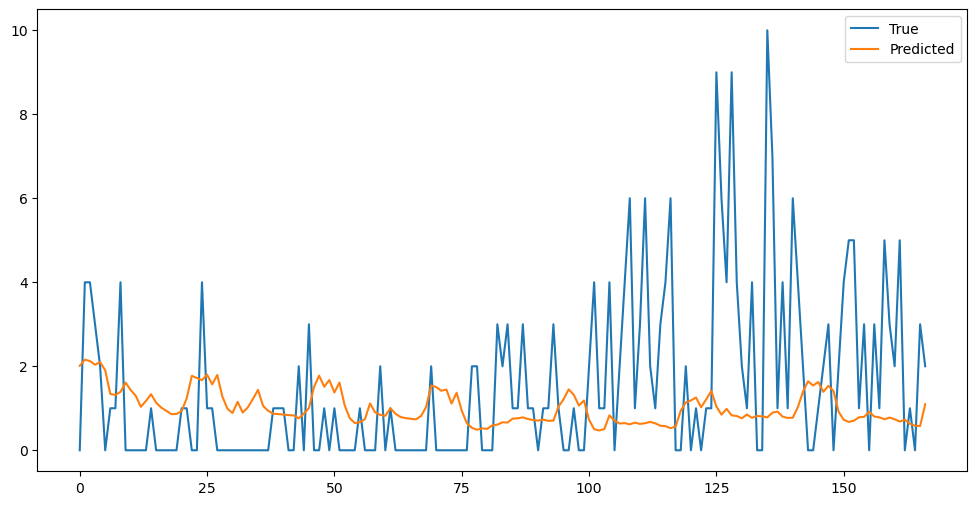

In [3]:
# Select relevant features and the target variable
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2']
target_variable = 'Long episodes'       # The variable we want to predict (seizure episodes)

# Preprocess the data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values with zeros (can use other strategies)
scaler = StandardScaler()              # Initialize a standard scaler for feature scaling
df[selected_features] = scaler.fit_transform(df[selected_features])  # Standardize the selected features

# Define the time window size (7 days)
sequence_length = 24 * 7               # Assuming hourly data, this defines a window of 7 days' worth of data

# Create sequences for training and testing using a smaller dataset
X, y = [], []                          # Initialize empty lists for storing input sequences (X) and target values (y)
sample_size = 1000                     # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    # Extract a sequence of length 'sequence_length' from the standardized features
    X.append(df[selected_features].values[i:i + sequence_length])
    # Extract the target variable (Long episodes) for the corresponding time period
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)         # Convert Python lists to NumPy arrays for model compatibility

# Calculate the number of data points for training and testing
total_samples = len(X)                 # Total number of samples in the dataset
train_size = int(0.8 * total_samples)  # Define the size of the training set as 80% of the data
test_size = total_samples - train_size # Define the size of the testing set as the remaining 20%

# Split the data into training and testing sets based on the calculated sizes
X_train, y_train = X[:train_size], y[:train_size]        # Training data
X_test, y_test = X[train_size:], y[train_size:]          # Testing data

# Define and configure the LSTM model
model = Sequential()                   # Initialize a sequential neural network model
model.add(LSTM(units=50, input_shape=(sequence_length, len(selected_features))))  # Add an LSTM layer
model.add(Dense(1))                    # Add a dense output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model with the Adam optimizer and MSE loss

# Train the model with a specified number of epochs and batch size
epochs = 5                            # Define the number of training epochs (adjust as needed)
model.fit(X_train, y_train, epochs=epochs, batch_size=32)  # Train the model on the training data

# Evaluate the model's performance on the test set
y_pred = model.predict(X_test)         # Make predictions on the test data
mae = mean_absolute_error(y_test, y_pred)  # Calculate the Mean Absolute Error (MAE) for evaluation
print(f'Mean Absolute Error: {mae}')   # Print the MAE as a measure of model accuracy

# Visualize the model's predictions against the true values (for demonstration purposes)
plt.figure(figsize=(12, 6))            # Set the figure size for the plot
plt.plot(y_test, label='True')         # Plot the true values from the test set
plt.plot(y_pred, label='Predicted')    # Plot the model's predictions
plt.legend()                           # Add a legend to the plot
plt.show()                             # Display the plot


A MAE of # means that, on average, the model's predictions are off by approximately # units with respect to the target variable (in this case, 'Long episodes'). 

- Fill Missing Values:
df[selected_features] = df[selected_features].fillna(0)
Why: Missing values are gaps in your data where no information is available. These gaps can cause issues when training machine learning models. Filling them with zeros is a simple strategy. Zeros are often used to indicate missing or unknown values, and they help ensure that your dataset is complete and ready for modeling.
Other Strategies: Depending on data and the nature of missing values, can consider alternative strategies like mean imputation (replacing missing values with the mean of the feature) or forward/backward filling (using the nearest available value).
 - Standardize Features:
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])
Why: Standardization (or z-score normalization) is a common preprocessing step in machine learning. It transforms the data such that each feature has a mean of 0 and a standard deviation of 1. This helps ensure that all features are on a similar scale, preventing some features from dominating the learning process simply because they have larger values. Standardization also makes optimization algorithms (like gradient descent) converge faster and can improve model performance.

- Data Training: 
This code loads the data, preprocesses it, creates sequences, splits it into training and testing sets (80% training, 20% testing)- sequentially. This means that the first 80% of your data (based on the order in the CSV file) is used for training, and the remaining 20% is used for testing. This can be suitable for time series data when the order of data points matters.

## Adding Total Predication 

# Try 1

Epoch 1/5
21/21 [==============================] - 2s 32ms/step - loss: 8.2853
Epoch 2/5
21/21 [==============================] - 1s 31ms/step - loss: 6.7938
Epoch 3/5
21/21 [==============================] - 1s 31ms/step - loss: 6.5891
Epoch 4/5
21/21 [==============================] - 1s 32ms/step - loss: 6.5287
Epoch 5/5
6/6 [==============================] - 1s 13ms/step
Mean Absolute Error: 1.5080543842144356


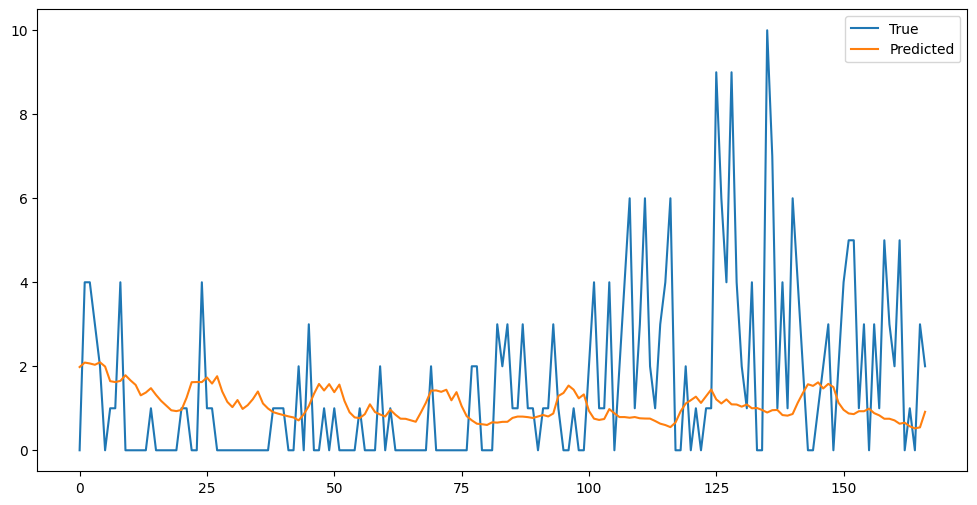

1/1 [==============================] - 0s 26ms/step
Forecasted Seizures in the Next 24 Hours: 2


In [31]:
# try 1 
# Select relevant features and target variable
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2']
target_variable = 'Long episodes'

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features]) #more notes 

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Create sequences for training and testing using a smaller dataset
X, y = [], []                          # Initialize empty lists for storing input sequences (X) and target values (y)
sample_size = 1000                     # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    # Extract a sequence of length 'sequence_length' from the standardized features
    X.append(df[selected_features].values[i:i + sequence_length])
    # Extract the target variable (Long episodes) for the corresponding time period
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)         # Convert Python lists to NumPy arrays for model compatibility

# Calculate the number of data points for training and testing
total_samples = len(X)                 # Total number of samples in the dataset
train_size = int(0.8 * total_samples)  # Define the size of the training set as 80% of the data
test_size = total_samples - train_size # Define the size of the testing set as the remaining 20%

# Split the data into training and testing sets based on the calculated sizes
X_train, y_train = X[:train_size], y[:train_size]        # Training data
X_test, y_test = X[train_size:], y[train_size:]          # Testing data

# Define and configure the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(sequence_length, len(selected_features))))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs
epochs = 5  # Adjust as needed
model.fit(X_train, y_train, epochs=epochs, batch_size=32)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Visualize predictions (example)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate the number of seizures in the next 24 hours
def forecast_seizures(data_point):
    # Predict the number of seizures for the data point
    prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
    return round(prediction)

# Choose a data point from the test set (you can replace this with any data point)
data_point_index = 0
data_point = X_test[data_point_index]

# Forecast seizures for the chosen data point
forecasted_seizures = forecast_seizures(data_point)
print(f'Forecasted Seizures in the Next 24 Hours: {forecasted_seizures}')


In [32]:
# Check distribution and statistics of the target variable
print(df['Long episodes'].describe())

# Check for negative values in the target variable
negative_values = (df['Long episodes'] < 0).sum()
print(f"Number of negative values in 'Long episodes': {negative_values}")

count    37863.000000
mean         2.008452
std          5.493604
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         59.000000
Name: Long episodes, dtype: float64
Number of negative values in 'Long episodes': 0


# Try 2

Epoch 1/5
21/21 [==============================] - 4s 51ms/step - loss: 9.1296
Epoch 2/5
21/21 [==============================] - 1s 51ms/step - loss: 6.9956
Epoch 3/5
21/21 [==============================] - 1s 50ms/step - loss: 6.6411
Epoch 4/5
21/21 [==============================] - 1s 50ms/step - loss: 6.5122
Epoch 5/5
6/6 [==============================] - 1s 16ms/step
Mean Absolute Error: 1.5511630914525358


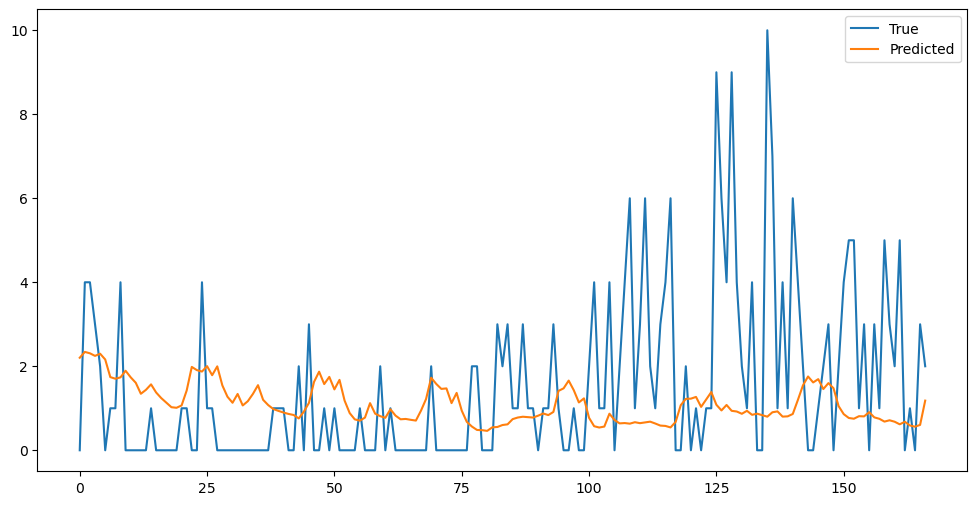

1/1 [==============================] - 0s 25ms/step
Forecasted Seizures in the Next 24 Hours: 2


In [3]:
# try 2 - 'Episode starts added'
# Select relevant features and target variable
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                    'Episode starts']
target_variable = 'Long episodes'

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features]) #more notes 

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Create sequences for training and testing using a smaller dataset
X, y = [], []                          # Initialize empty lists for storing input sequences (X) and target values (y)
sample_size = 1000                     # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    # Extract a sequence of length 'sequence_length' from the standardized features
    X.append(df[selected_features].values[i:i + sequence_length])
    # Extract the target variable (Long episodes) for the corresponding time period
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)         # Convert Python lists to NumPy arrays for model compatibility

# Calculate the number of data points for training and testing
total_samples = len(X)                 # Total number of samples in the dataset
train_size = int(0.8 * total_samples)  # Define the size of the training set as 80% of the data
test_size = total_samples - train_size # Define the size of the testing set as the remaining 20%

# Split the data into training and testing sets based on the calculated sizes
X_train, y_train = X[:train_size], y[:train_size]        # Training data
X_test, y_test = X[train_size:], y[train_size:]          # Testing data

# Define and configure the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(sequence_length, len(selected_features))))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs
epochs = 5  # Adjust as needed
model.fit(X_train, y_train, epochs=epochs, batch_size=32)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Visualize predictions (example)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate the number of seizures in the next 24 hours
def forecast_seizures(data_point):
    # Predict the number of seizures for the data point
    prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
    return round(prediction)

# Choose a data point from the test set (you can replace this with any data point)
data_point_index = 0
data_point = X_test[data_point_index]

# Forecast seizures for the chosen data point
forecasted_seizures = forecast_seizures(data_point)
print(f'Forecasted Seizures in the Next 24 Hours: {forecasted_seizures}')


In [8]:
# Check distribution and statistics of the target variable
print(df['Long episodes'].describe())

# Check for negative values in the target variable
negative_values = (df['Long episodes'] < 0).sum()
print(f"Number of negative values in 'Long episodes': {negative_values}")


count    3.787500e+04
mean    -3.902122e-17
std      1.000013e+00
min     -3.655373e-01
25%     -3.655373e-01
50%     -3.655373e-01
75%     -1.834801e-01
max      1.037584e+01
Name: Long episodes, dtype: float64
Number of negative values in 'Long episodes': 31530


# Try 3

Epoch 1/5
21/21 [==============================] - 3s 53ms/step - loss: 0.2268
Epoch 2/5
21/21 [==============================] - 1s 52ms/step - loss: 0.2044
Epoch 3/5
21/21 [==============================] - 1s 53ms/step - loss: 0.1935
Epoch 4/5
21/21 [==============================] - 1s 53ms/step - loss: 0.1867
Epoch 5/5
6/6 [==============================] - 1s 16ms/step
Mean Absolute Error: 0.2618852375045224


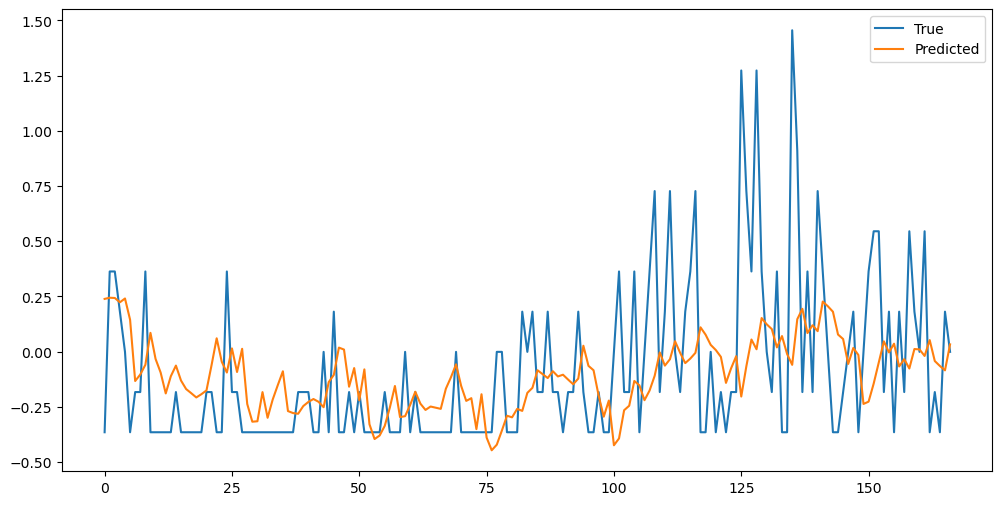

1/1 [==============================] - 0s 25ms/step
Forecasted Seizures in the Next 24 Hours: 0


In [4]:
# try 3 - 'long episode added', 'Episode starts'
# Select relevant features and target variable
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                    'Long episodes','Episode starts']
target_variable = 'Long episodes'

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features]) #more notes 

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Create sequences for training and testing using a smaller dataset
X, y = [], []                          # Initialize empty lists for storing input sequences (X) and target values (y)
sample_size = 1000                     # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    # Extract a sequence of length 'sequence_length' from the standardized features
    X.append(df[selected_features].values[i:i + sequence_length])
    # Extract the target variable (Long episodes) for the corresponding time period
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)         # Convert Python lists to NumPy arrays for model compatibility

# Calculate the number of data points for training and testing
total_samples = len(X)                 # Total number of samples in the dataset
train_size = int(0.8 * total_samples)  # Define the size of the training set as 80% of the data
test_size = total_samples - train_size # Define the size of the testing set as the remaining 20%

# Split the data into training and testing sets based on the calculated sizes
X_train, y_train = X[:train_size], y[:train_size]        # Training data
X_test, y_test = X[train_size:], y[train_size:]          # Testing data

# Define and configure the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(sequence_length, len(selected_features))))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs
epochs = 5  # Adjust as needed
model.fit(X_train, y_train, epochs=epochs, batch_size=32)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Visualize predictions (example)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate the number of seizures in the next 24 hours
def forecast_seizures(data_point):
    # Predict the number of seizures for the data point
    prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
    return round(prediction)

# Choose a data point from the test set (you can replace this with any data point)
data_point_index = 0
data_point = X_test[data_point_index]

# Forecast seizures for the chosen data point
forecasted_seizures = forecast_seizures(data_point)
print(f'Forecasted Seizures in the Next 24 Hours: {forecasted_seizures}')


In [5]:
# Check distribution and statistics of the target variable
print(df['Long episodes'].describe())

# Check for negative values in the target variable
negative_values = (df['Long episodes'] < 0).sum()
print(f"Number of negative values in 'Long episodes': {negative_values}")

count    3.787500e+04
mean    -3.902122e-17
std      1.000013e+00
min     -3.655373e-01
25%     -3.655373e-01
50%     -3.655373e-01
75%     -1.834801e-01
max      1.037584e+01
Name: Long episodes, dtype: float64
Number of negative values in 'Long episodes': 31530


# Try 4 

Epoch 1/5
21/21 [==============================] - 3s 58ms/step - loss: 0.6330
Epoch 2/5
21/21 [==============================] - 1s 57ms/step - loss: 0.4142
Epoch 3/5
21/21 [==============================] - 1s 58ms/step - loss: 0.3821
Epoch 4/5
21/21 [==============================] - 1s 56ms/step - loss: 0.3619
Epoch 5/5
6/6 [==============================] - 1s 18ms/step
Mean Absolute Error: 0.6780094757029816


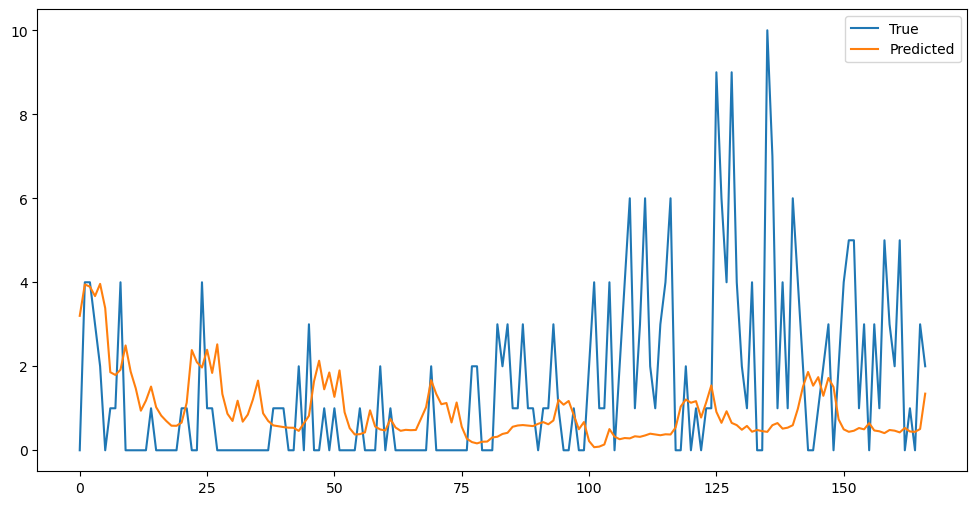

1/1 [==============================] - 0s 24ms/step
Forecasted Seizures in the Next 24 Hours: 3


In [7]:
# logarithmic transformation + 'long episode' as a feature 
# Transform the target variable using a logarithmic transformation
df['Log Long episodes'] = np.log1p(df['Long episodes'])

# Select relevant features (excluding 'Long episodes') and target variable
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                     'Episode starts']
target_variable = 'Log Long episodes'  # Use the transformed target variable

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Create sequences for training and testing using a smaller dataset
X, y = [], []                          # Initialize empty lists for storing input sequences (X) and target values (y)
sample_size = 1000                     # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    # Extract a sequence of length 'sequence_length' from the standardized features
    X.append(df[selected_features].values[i:i + sequence_length])
    # Extract the log-transformed target variable ('Log Long episodes') for the corresponding time period
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)         # Convert Python lists to NumPy arrays for model compatibility

# Calculate the number of data points for training and testing
total_samples = len(X)                 # Total number of samples in the dataset
train_size = int(0.8 * total_samples)  # Define the size of the training set as 80% of the data
test_size = total_samples - train_size # Define the size of the testing set as the remaining 20%

# Split the data into training and testing sets based on the calculated sizes
X_train, y_train = X[:train_size], y[:train_size]        # Training data
X_test, y_test = X[train_size:], y[train_size:]          # Testing data

# Define and configure the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(sequence_length, len(selected_features))))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs
epochs = 5  # Adjust as needed
model.fit(X_train, y_train, epochs=epochs, batch_size=32)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Visualize predictions (example)
plt.figure(figsize=(12, 6))
plt.plot(np.expm1(y_test), label='True')  # Reverse the logarithmic transformation for visualization
plt.plot(np.expm1(y_pred), label='Predicted')  # Reverse the logarithmic transformation for visualization
plt.legend()
plt.show()

# In the forecasting function, you'll need to reverse the logarithmic transformation
def forecast_seizures(data_point):
    # Predict the log-transformed number of seizures for the data point
    log_prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
    # Reverse the logarithmic transformation
    prediction = np.expm1(log_prediction)
    return round(prediction)

# Choose a data point from the test set (you can replace this with any data point)
data_point_index = 0
data_point = X_test[data_point_index]

# Forecast seizures for the chosen data point
forecasted_seizures = forecast_seizures(data_point)
print(f'Forecasted Seizures in the Next 24 Hours: {forecasted_seizures}')


Epoch 1/5
21/21 [==============================] - 3s 51ms/step - loss: 0.5809
Epoch 2/5
21/21 [==============================] - 1s 52ms/step - loss: 0.4463
Epoch 3/5
21/21 [==============================] - 1s 53ms/step - loss: 0.4007
Epoch 4/5
21/21 [==============================] - 1s 52ms/step - loss: 0.3839
Epoch 5/5
6/6 [==============================] - 1s 14ms/step
Mean Absolute Error: 0.5881885525117905


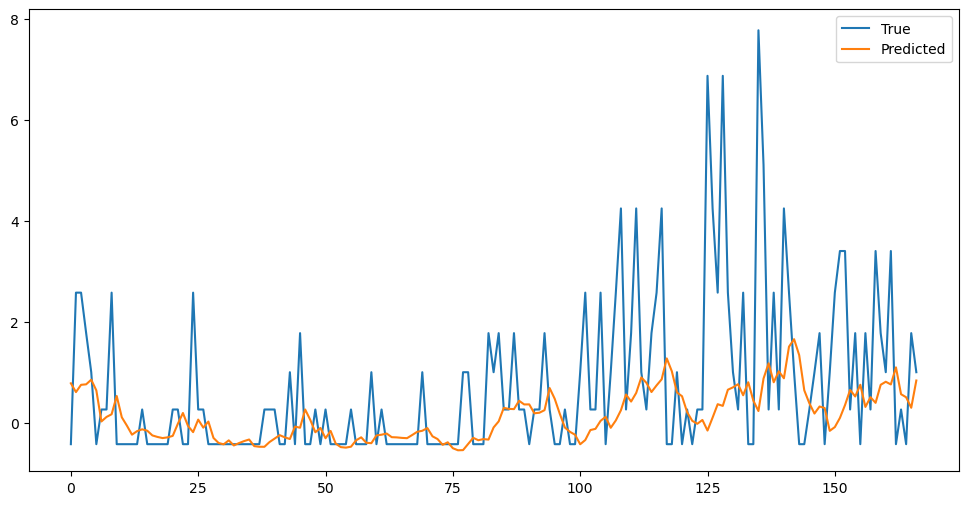

1/1 [==============================] - 0s 15ms/step
Forecasted Seizures in the Next 24 Hours: 1


In [6]:
# logarithmic transformation + 'long episode' as a feature 
# Transform the target variable using a logarithmic transformation
df['Log Long episodes'] = np.log1p(df['Long episodes'])

# Select relevant features (excluding 'Long episodes') and target variable
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                     'Episode starts','Log Long episodes']
target_variable = 'Log Long episodes'  # Use the transformed target variable

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Create sequences for training and testing using a smaller dataset
X, y = [], []                          # Initialize empty lists for storing input sequences (X) and target values (y)
sample_size = 1000                     # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    # Extract a sequence of length 'sequence_length' from the standardized features
    X.append(df[selected_features].values[i:i + sequence_length])
    # Extract the log-transformed target variable ('Log Long episodes') for the corresponding time period
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)         # Convert Python lists to NumPy arrays for model compatibility

# Calculate the number of data points for training and testing
total_samples = len(X)                 # Total number of samples in the dataset
train_size = int(0.8 * total_samples)  # Define the size of the training set as 80% of the data
test_size = total_samples - train_size # Define the size of the testing set as the remaining 20%

# Split the data into training and testing sets based on the calculated sizes
X_train, y_train = X[:train_size], y[:train_size]        # Training data
X_test, y_test = X[train_size:], y[train_size:]          # Testing data

# Define and configure the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(sequence_length, len(selected_features))))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs
epochs = 5  # Adjust as needed
model.fit(X_train, y_train, epochs=epochs, batch_size=32)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Visualize predictions (example)
plt.figure(figsize=(12, 6))
plt.plot(np.expm1(y_test), label='True')  # Reverse the logarithmic transformation for visualization
plt.plot(np.expm1(y_pred), label='Predicted')  # Reverse the logarithmic transformation for visualization
plt.legend()
plt.show()

# In the forecasting function, you'll need to reverse the logarithmic transformation
def forecast_seizures(data_point):
    # Predict the log-transformed number of seizures for the data point
    log_prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
    # Reverse the logarithmic transformation
    prediction = np.expm1(log_prediction)
    return round(prediction)

# Choose a data point from the test set (you can replace this with any data point)
data_point_index = 0
data_point = X_test[data_point_index]

# Forecast seizures for the chosen data point
forecasted_seizures = forecast_seizures(data_point)
print(f'Forecasted Seizures in the Next 24 Hours: {forecasted_seizures}')


'Long episodes' (target variable) shoudl not be added to the features when building a predictive model. Including the target variable as a feature would lead to data leakage, as the model would effectively have access to the future information it's trying to predict, which would result in unrealistic and overly optimistic model performance.

The 'Long episodes' should be used as the target variable for your predictive model, and we could use other features (like 'Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2', and 'Episode starts') as input features to predict 'Long episodes' in the future.

In the code, I used the logarithmically transformed 'Log Long episodes' as the target variable for the LSTM model. This transformation helps improve the stability of the predictions, especially if 'Long episodes' have a wide range of values or include zeros.

# Try to adjust timeline - predcit the next day 

## Step 1: Train and Save the Model (the model above)

Epoch 1/5
21/21 [==============================] - 3s 54ms/step - loss: 0.4000
Epoch 2/5
21/21 [==============================] - 1s 53ms/step - loss: 0.3454
Epoch 3/5
21/21 [==============================] - 1s 54ms/step - loss: 0.3191
Epoch 4/5
21/21 [==============================] - 1s 56ms/step - loss: 0.3102
Epoch 5/5
6/6 [==============================] - 1s 15ms/step
Mean Absolute Error: 0.47501485036577845


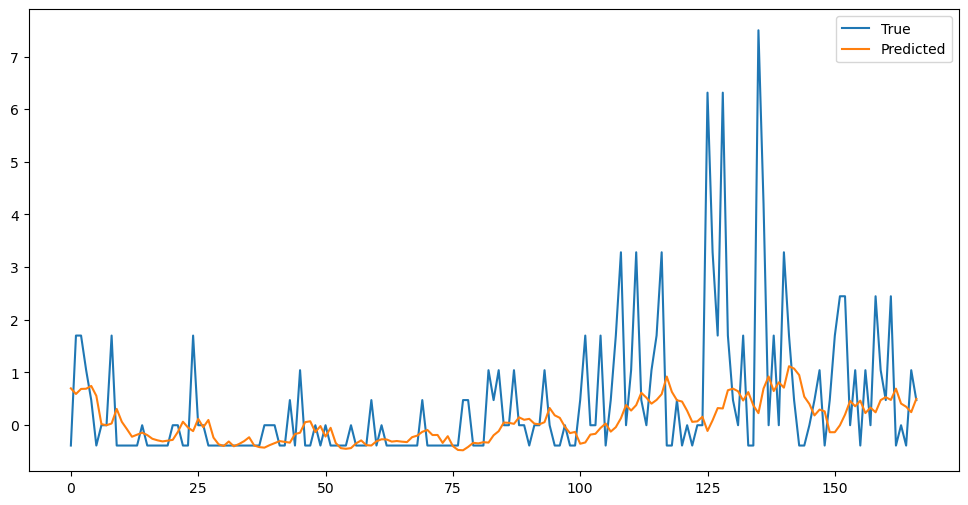

1/1 [==============================] - 0s 31ms/step
Forecasted Seizures in the Next 24 Hours: 1


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Logarithmic transformation + 'long episode' as a feature
# Transform the target variable using a logarithmic transformation
df['Log Long episodes'] = np.log1p(df['Long episodes'])

# Select relevant features (excluding 'Long episodes') and target variable
selected_features = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2',
                     'Episode starts', 'Log Long episodes']
target_variable = 'Log Long episodes'  # Use the transformed target variable

# Preprocess data
df[selected_features] = df[selected_features].fillna(0)  # Fill missing values (you can use other strategies)
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

# Define time window size (7 days)
sequence_length = 24 * 7  # Assuming hourly data

# Create sequences for training and testing using a smaller dataset
X, y = [], []  # Initialize empty lists for storing input sequences (X) and target values (y)
sample_size = 1000  # Use a smaller sample size for demonstration purposes
for i in range(sample_size - sequence_length):
    # Extract a sequence of length 'sequence_length' from the standardized features
    X.append(df[selected_features].values[i:i + sequence_length])
    # Extract the log-transformed target variable ('Log Long episodes') for the corresponding time period
    y.append(df[target_variable].values[i + sequence_length])

X, y = np.array(X), np.array(y)  # Convert Python lists to NumPy arrays for model compatibility

# Calculate the number of data points for training and testing
total_samples = len(X)  # Total number of samples in the dataset
train_size = int(0.8 * total_samples)  # Define the size of the training set as 80% of the data
test_size = total_samples - train_size  # Define the size of the testing set as the remaining 20%

# Split the data into training and testing sets based on the calculated sizes
X_train, y_train = X[:train_size], y[:train_size]  # Training data
X_test, y_test = X[train_size:], y[train_size:]  # Testing data

# Define and configure the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(sequence_length, len(selected_features))))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with fewer epochs
epochs = 5  # Adjust as needed
model.fit(X_train, y_train, epochs=epochs, batch_size=32)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Visualize predictions (example)
plt.figure(figsize=(12, 6))
plt.plot(np.expm1(y_test), label='True')  # Reverse the logarithmic transformation for visualization
plt.plot(np.expm1(y_pred), label='Predicted')  # Reverse the logarithmic transformation for visualization
plt.legend()
plt.show()

# In the forecasting function, you'll need to reverse the logarithmic transformation
def forecast_seizures(data_point):
    # Predict the log-transformed number of seizures for the data point
    log_prediction = model.predict(data_point.reshape(1, sequence_length, len(selected_features)))[0][0]
    # Reverse the logarithmic transformation
    prediction = np.expm1(log_prediction)
    return round(prediction)

# Choose a data point from the test set (you can replace this with any data point)
data_point_index = 0
data_point = X_test[data_point_index]

# Forecast seizures for the chosen data point
forecasted_seizures = forecast_seizures(data_point)
print(f'Forecasted Seizures in the Next 24 Hours: {forecasted_seizures}')


# Save the trained model for future use
model.save('seizure_prediction_model.h5')

## Step 2: Load the Trained Model

In [20]:
# Load the saved model
loaded_model = load_model('seizure_prediction_model.h5')

# Example: Prepare input data for prediction (similar to your previous code)
data_point_index = 30 # could be replaced with with the index of the data point you want to predict
data_point = X_test[data_point_index]

# Forecast seizures for the chosen data point using the loaded model
forecasted_seizures = forecast_seizures(data_point)
print(f'Forecasted Seizures in the Next 24 Hours: {forecasted_seizures}')

1/1 [==============================] - 0s 31ms/step
Forecasted Seizures in the Next 24 Hours: 0


## Step 3: Prepare and Predict on New Data